In [4]:
pip install tensorflow tensorflow_addons catboost optuna

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.9 MB/s eta 0:00:0000:01
Note: you may need to restart the kernel to use updated packages.


In [38]:
import boto3
import numpy as np 
import pandas as pd

import plotly.graph_objs as go
from plotly.subplots import make_subplots
# from plotly.offline import init_notebook_mode
# init_notebook_mode(connected=True)

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm import tqdm
tqdm.pandas()

import warnings
warnings.filterwarnings("ignore")
import gc

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error as mae

# from umap import UMAP

import optuna
import catboost as cb

import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.layers import Dense, Dropout, Input

seed = 827
np.random.seed(seed)
tf.random.set_seed(seed)

# Read files
# path = '/kaggle/input/playground-series-s3e2/'
# train = pd.read_csv(path+'train.csv')
# test = pd.read_csv(path+'test.csv')
# ss = pd.read_csv(path+'sample_submission.csv')

# orig_train = pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
# train.drop('id', axis=1, inplace=True)
# orig_train.drop('id', axis=1, inplace=True)
# test.drop('id', axis=1, inplace=True)


s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-2/train.csv'
file_key_2 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-2/test.csv'
file_key_3 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-2/sample_submission.csv'
file_key_4 = 'Tabular-Playground-Series/Tabular-Playground-Jan-2023-2/healthcare-dataset-stroke-data.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

bucket_object_3 = bucket.Object(file_key_3)
file_object_3 = bucket_object_3.get()
file_content_stream_3 = file_object_3.get('Body')

bucket_object_4 = bucket.Object(file_key_4)
file_object_4 = bucket_object_4.get()
file_content_stream_4 = file_object_4.get('Body')

## Reading data files
train = pd.read_csv(file_content_stream_1)
train = train.drop('id', axis = 1)

test = pd.read_csv(file_content_stream_2)
test = test.drop('id', axis = 1)

ss = pd.read_csv(file_content_stream_3)

orig_train = pd.read_csv(file_content_stream_4)
orig_train = orig_train.drop('id', axis = 1)

# # Show all columns
# pd.set_option('display.max_columns', None)

# # Bold font
bold = ['\033[1m', '\033[0m']

![](https://www.brainandlife.org/siteassets/online-exclusives/covid-19/stroke-main.jpg)

# <div style="background-color:#72bfd6;text-align:center;color:white;font-size:150%;font-family:Calibri;border-radius:10px"> <b>EDA</b></div>

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#72bfd6;font-size:200%;font-family:Calibri'> Missing values</span></b>

We have missing values only in original data for bmi (3.93%).

In [2]:
def mv(df, name):
    l = len(df)
    df = df.isna().sum().to_frame().reset_index() \
             .rename({'index': 'feature', 0: name}, axis=1)
    df[name] = round(df[name]/l*100, 2)
    return df
    
train_mv = mv(train, 'train (kaggle), %')
orig_train_mv = mv(orig_train, 'train (original), %')
test_mv = mv(test, 'test, %')
mv_df = train_mv.merge(orig_train_mv, on='feature', how='right') \
                .merge(test_mv, on='feature', how='right')

for col in mv_df.columns[1:]:
    mv_df[col] = mv_df[col].astype('str')
    
mv_df = mv_df.style.hide_index() \
        .set_table_styles([
        {'selector': 'th.col_heading', 'props': 'font-size: 12pt; text-align: center; font-weight: bold; border: 1px solid black !important'},
        {'selector': 'td', 'props': 'text-align: center; font-size: 10pt; border: 1px solid black !important'},
        {'selector': 'th:not(.index_name)', 'props': 'background-color: #72bfd6; color: white;'}
        ], overwrite=False).set_properties(subset=['feature'], **{'font-weight': 'bold'})
mv_df

feature,"train (kaggle), %","train (original), %","test, %"
gender,0.0,0.0,0.0
age,0.0,0.0,0.0
hypertension,0.0,0.0,0.0
heart_disease,0.0,0.0,0.0
ever_married,0.0,0.0,0.0
work_type,0.0,0.0,0.0
Residence_type,0.0,0.0,0.0
avg_glucose_level,0.0,0.0,0.0
bmi,0.0,3.93,0.0
smoking_status,0.0,0.0,0.0


I'll try to restore them with KNN. It's better than just putting the average.

In [11]:
num_cols = test.select_dtypes(include=np.number).columns.tolist()
num_cols.remove('hypertension') # in fact, this is a categorical feature
num_cols.remove('heart_disease') # and this is too
cat_cols = list(set(test.columns) - set(num_cols))
df = orig_train.copy()

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    
cols = ['age', 'ever_married', 'work_type', 
        'smoking_status', 'avg_glucose_level', 
        'hypertension', 'heart_disease']
knn = KNeighborsRegressor(n_neighbors=100,
                          metric='minkowski',
                          n_jobs=-1)
knn.fit(df[cols], df.index)
dists, nears = knn.kneighbors(df[cols], return_distance=True)

# Check results
result = []
for i, n in enumerate(nears):
    n = list(n)
    n.remove(i)
    try:
        avg_bmi = df.iloc[n]['bmi'].median()
        result.append(mae(np.array([df.iloc[i]['bmi']]), 
                          np.array([avg_bmi])))
    except:
        continue
        
print(f'MAE mean score: {round(np.mean(result), 2)}')
print(f'MAE median score: {round(np.median(result), 2)}')

# Restore missing values
result = []
for i in df.query('bmi!=bmi').index:
    result.append(round(df.iloc[nears[i]]['bmi'].median(),1))
df.loc[orig_train.query('bmi!=bmi').index, 'bmi'] = result
orig_train['bmi'] = df['bmi']

MAE mean score: 4.91
MAE median score: 3.65


<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#72bfd6;font-size:200%;font-family:Calibri'> Features distribution</span></b>

The distribution of original train data is different from the distribution of the generated train and test data.

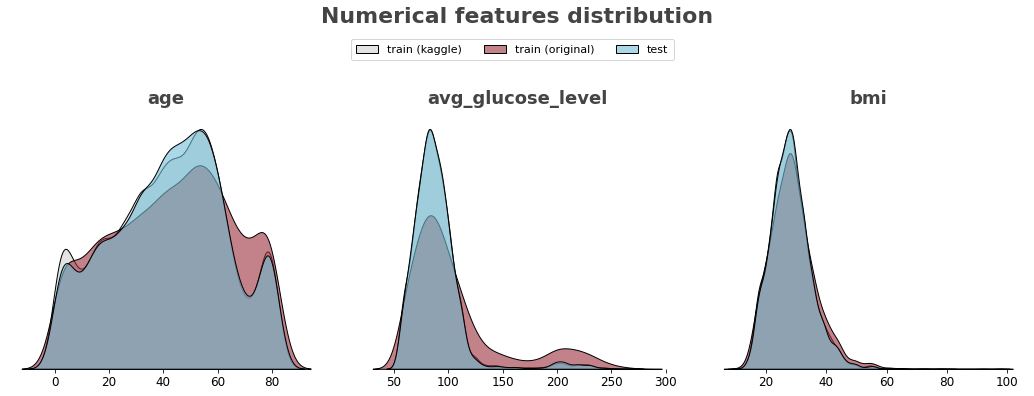

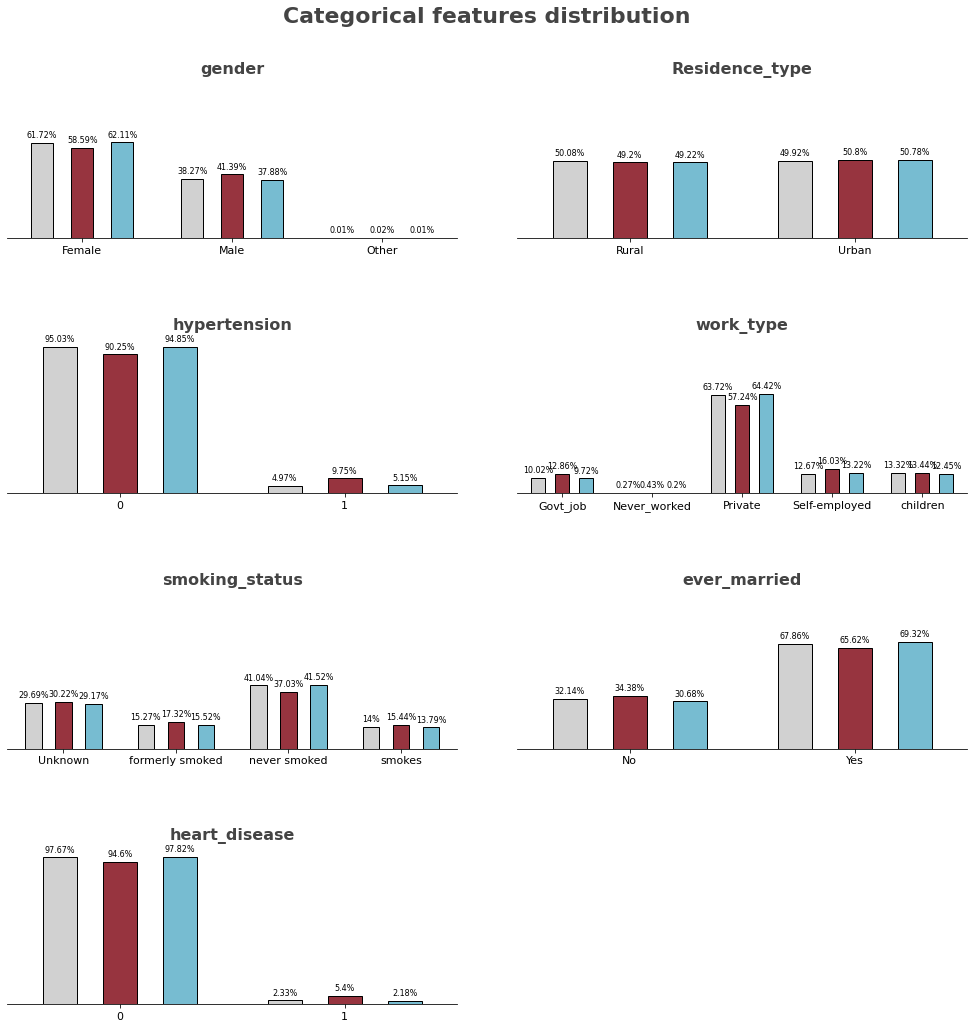

In [4]:
fig = plt.figure(figsize = (15, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1,3,i+1)
    plt.title(col, size=18, y=1.03, fontname='Calibri', 
              fontweight='bold', color='#444444')
    a = sns.kdeplot(train[col], color='#d1d1d1', 
                    shade=True, label='train kaggle', 
                    alpha=0.6, edgecolor='black')
    sns.kdeplot(orig_train[col], color='#9c2f3b', 
                shade=True, label='train original', 
                alpha=0.6, edgecolor='black')
    sns.kdeplot(test[col], color='#72bfd6', 
                shade=True, label='test', 
                alpha=0.6, edgecolor='black')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=12)
    plt.yticks([])
    for s in ['right', 'top', 'left', 'bottom']:
        a.spines[s].set_visible(False)
        
fig.tight_layout(pad=3)
fig.legend(['train (kaggle)', 'train (original)', 'test'], bbox_to_anchor=(0.65, 1.07), 
           ncol=3, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.1, 'Numerical features distribution', 
            fontname='Calibri', fontweight='bold',
            size=22, color='#444444', ha='center') 
plt.show()

###########################################

print()
print()
cat_cols = list(set(test.columns) - set(num_cols))

train['data'] = 'kaggle'
orig_train['data'] = 'original'
test['data'] = 'test'
df = pd.concat([train, orig_train, test])

l = {'kaggle': len(train), 'original': len(orig_train), 'test': len(test)}

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

fig = plt.figure(figsize=(15, 15))
for i, col in enumerate(cat_cols):
    df_plot = df.groupby(['data', col], as_index=False) \
                  ['age'].count().rename({'age': 'count'}, axis=1)
    df_plot['len_data'] = df_plot['data'].apply(lambda x: l[x])
    df_plot['count'] = round(df_plot['count'] / df_plot['len_data'] * 100, 2)
    
    plt.subplot(4,2,i+1)
    plt.title(col, size=16, y=1.03, fontname='Calibri', 
              fontweight='bold', color='#444444')
    a = sns.barplot(data=df_plot, x=col, y='count', hue='data',
                    palette=['#d1d1d1', '#9c2f3b', '#72bfd6'], 
                    linestyle="-", linewidth=1, edgecolor="black", 
                    saturation=0.9)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=11)
    a.set_yticks([0, 100])
    plt.yticks([])

    for p in a.patches:
        height = p.get_height()
        a.annotate(f'{height:g}%', (p.get_x() + p.get_width() / 2, p.get_height()+2), 
                   ha='center', va='center', size=8,xytext=(0, 5), 
                   textcoords='offset points')
    
    for s in ['right', 'top', 'left']:
        a.spines[s].set_visible(False)

    a.legend().set_visible(False)
    change_width(a, 0.15)

fig.tight_layout(pad=6)
plt.figtext(0.5, 0.98, 'Categorical features distribution', 
            fontname='Calibri', fontweight='bold',
            size=22, color='#444444', ha='center') 
plt.show()

<p style="text-align:justify;">
As the analysis shows, it is unsafe to use data from the original dataset in this competition due to the difference in distribution. It may seem insignificant, however, as the training of models has shown, when using the original data, the final result becomes worse. Marking up data about generation increases the CV score, but at the same time worsens the final results. However, the data on patients who have had a stroke from original data will be added to the training model, as they are an important addition to improving the possibility of separating the two classes.
</p>

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#72bfd6;font-size:200%;font-family:Calibri'> Target distribution</span></b>

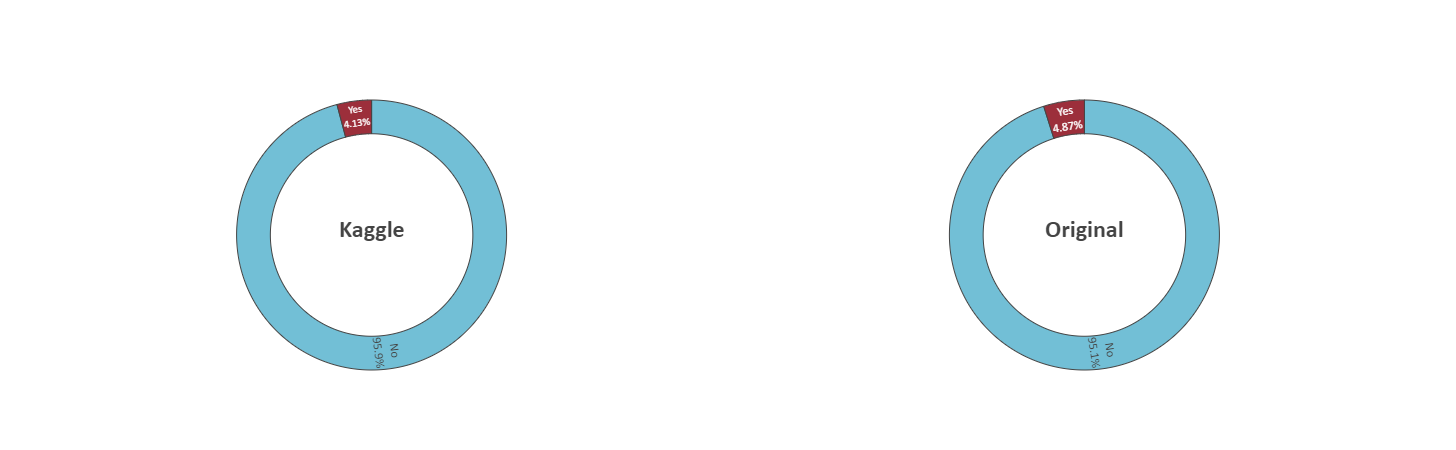

In [5]:
fig = make_subplots(rows=1, cols=2, 
                    vertical_spacing=0.1,
                    specs=[[{"type": "pie"}, {"type": "pie"}]],
                    subplot_titles=('<b>Kaggle</b>',  
                                    '<b>Original</b>'))
for i, df in enumerate([train, orig_train]):
    info = df['stroke'].value_counts().reset_index()
    info['index'] = info['index'].map({0: 'No', 1: 'Yes'})
    fig.add_trace(go.Pie(labels=info['index'],
                         values=info['stroke'],
                         textinfo='label+percent',
                         textposition = 'inside',
                         hoverinfo='value',
                         textfont_size=22,
                         marker=dict(colors=['#72bfd6', '#9c2f3b'],
                                     line=dict(color='#444444', width=1)),
                         hole=0.75,
                         showlegend=False),
                  row=1, col=i+1)
    
fig.update_layout(width=750, height=450, plot_bgcolor='white',
                  font_family="Calibri", font_color="#444444",
                  hoverlabel=dict(font_size=14, font_family="Calibri"))

fig.layout.annotations[0].update(x=0.225, y=0.46, font_size=24)
fig.layout.annotations[1].update(x=0.775, y=0.46, font_size=24)

fig.show()

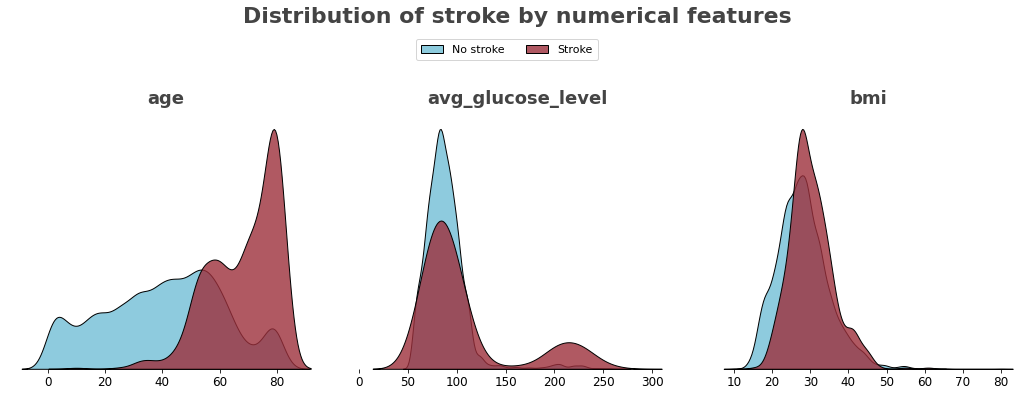

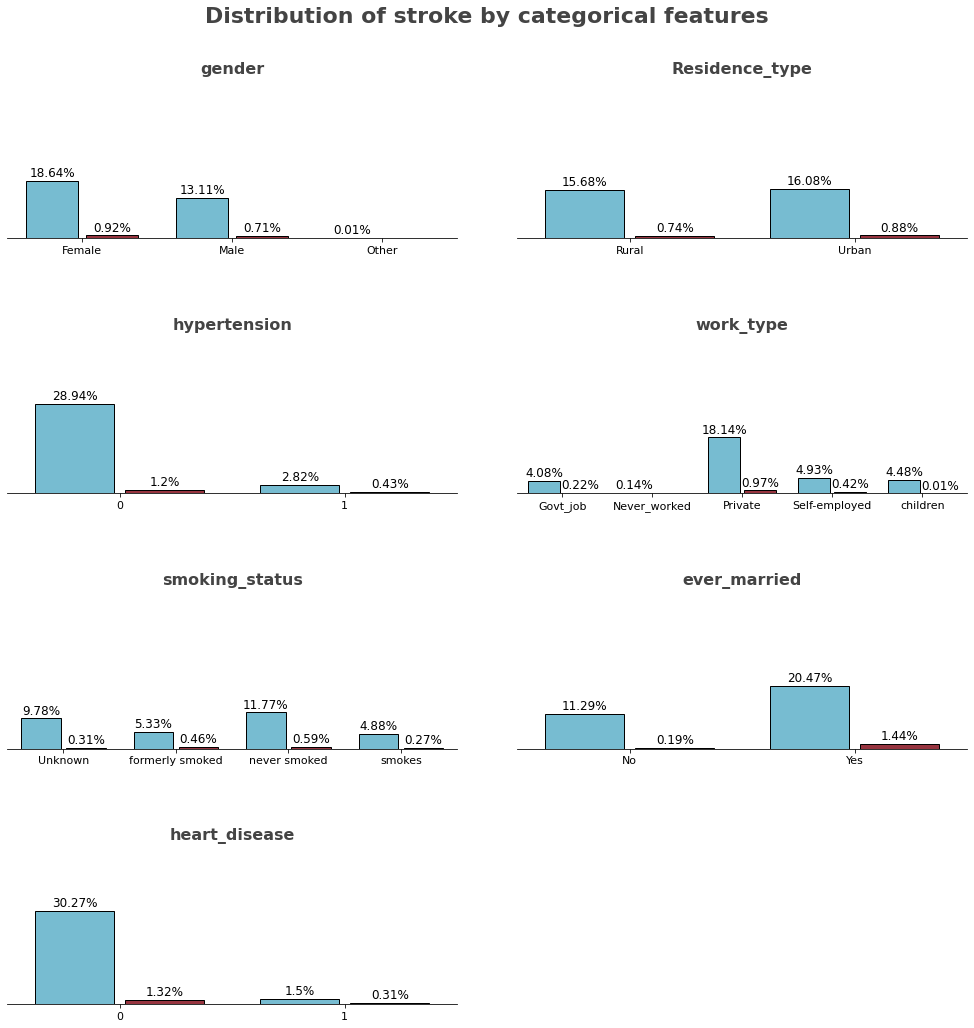

In [6]:
fig = plt.figure(figsize = (15, 5))
for i, col in enumerate(num_cols):
    plt.subplot(1,3,i+1)
    plt.title(col, size=18, y=1.03, fontname='Calibri', 
              fontweight='bold', color='#444444')
    a = sns.kdeplot(train[train['stroke']==0][col], 
                    color='#72bfd6', label='No stroke', 
                    shade=True, alpha=0.8, edgecolor='black')
    sns.kdeplot(train[train['stroke']==1][col], color='#9c2f3b', 
                shade=True, label='Stroke', 
                alpha=0.8, edgecolor='black')
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=12)
    plt.yticks([])
    for s in ['right', 'top', 'left', 'bottom']:
        a.spines[s].set_visible(False)
        
fig.tight_layout(pad=3)
fig.legend(['No stroke', 'Stroke'], bbox_to_anchor=(0.58, 1.07), 
           ncol=2, borderpad=0.5, frameon=True, fontsize=11, title_fontsize=12)
plt.figtext(0.5, 1.1, 'Distribution of stroke by numerical features', 
            fontname='Calibri', fontweight='bold',
            size=22, color='#444444', ha='center') 
plt.show()

###########################################

print()
print()

def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value
        patch.set_width(new_value)
        patch.set_x(patch.get_x() + diff * .5)

fig = plt.figure(figsize=(15, 15))
for i, col in enumerate(cat_cols):
    df_plot = df.groupby(['stroke', col], as_index=False) \
                  ['age'].count().rename({'age': 'count'}, axis=1)
    df_plot['count'] = round(df_plot['count'] / len(train) * 100, 2)
    
    plt.subplot(4,2,i+1)
    plt.title(col, size=16, y=1.03, fontname='Calibri', 
              fontweight='bold', color='#444444')
    a = sns.barplot(data=df_plot, x=col, y='count', hue='stroke',
                    palette=['#72bfd6', '#9c2f3b'], 
                    linestyle="-", linewidth=1, edgecolor="black", 
                    saturation=0.9)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=11)
    a.set_yticks([0, 50])
    plt.yticks([])

    for p in a.patches:
        height = p.get_height()
        a.annotate(f'{height:g}%', (p.get_x() + p.get_width() / 2, p.get_height()+1), 
                   ha='center', va='center', size=12, xytext=(0, 5), 
                   textcoords='offset points')
    
    for s in ['right', 'top', 'left']:
        a.spines[s].set_visible(False)

    a.legend().set_visible(False)
    change_width(a, 0.35)

fig.tight_layout(pad=6)
plt.figtext(0.5, 0.98, 'Distribution of stroke by categorical features', 
            fontname='Calibri', fontweight='bold',
            size=22, color='#444444', ha='center') 
plt.show()

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#72bfd6;font-size:200%;font-family:Calibri'> Correlation map</span></b>

Before building a correlation map, I will finally combine the necessary data from the original.

In [7]:
orig_train = orig_train[orig_train['stroke']==1]
train = pd.concat([orig_train, train], ignore_index=True)
train.drop('data', axis=1, inplace=True) # This column was created to build a barplot
test.drop('data', axis=1, inplace=True)
df = train.copy()

for col in cat_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

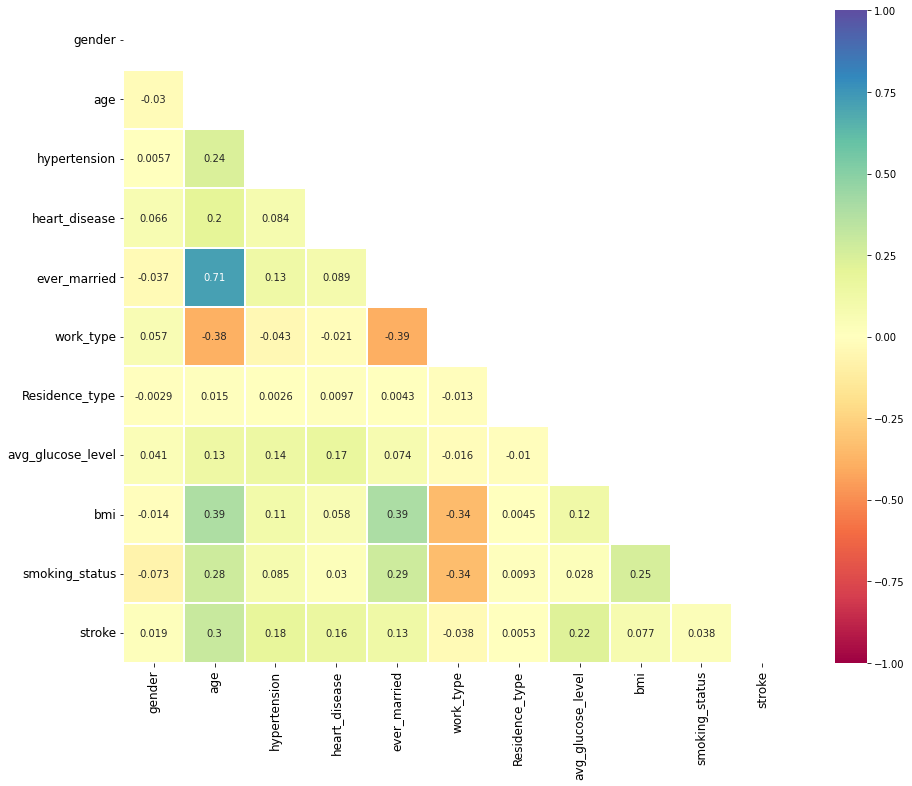

In [8]:
matrix = np.triu(df.corr())
plt.figure(figsize = (15, 12))
sns.heatmap(df.corr(), annot=True, cmap='Spectral', mask=matrix, 
            vmin=-1, vmax=1, linewidths=0.1, linecolor='white', cbar=True)
plt.xticks(size=12, fontname='Calibri')
plt.yticks(size=12, fontname='Calibri')
plt.show()

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#72bfd6;font-size:200%;font-family:Calibri'> UMAP</span></b>

There is a good division of classes.

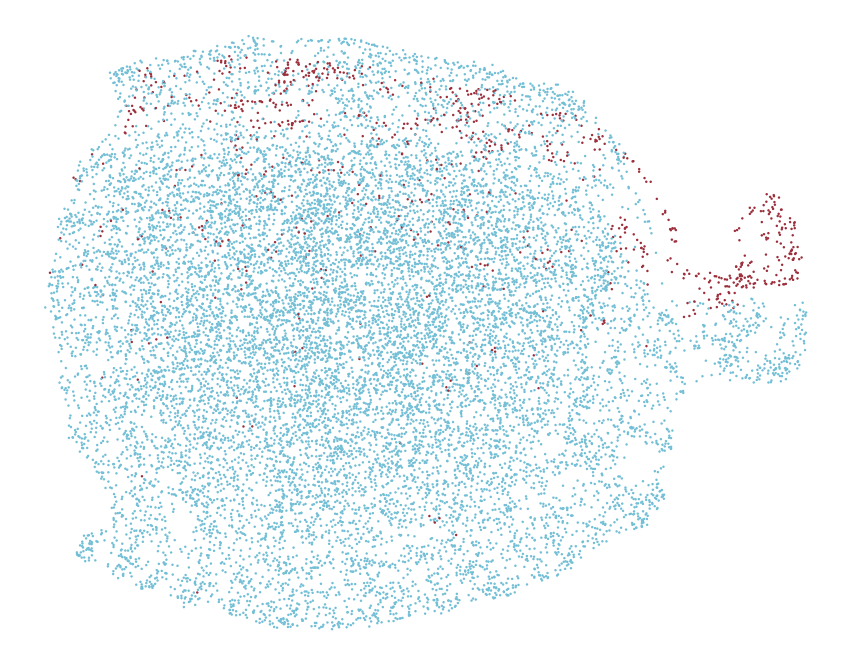

In [9]:
umap = UMAP(n_components=2, 
            n_neighbors=20, 
            min_dist=1,
            random_state=seed).fit_transform(df.drop('stroke', axis=1), 
                                            df['stroke'])
plt.figure(figsize=(15, 12))
a = sns.scatterplot(x=umap[:,0],
                    y=umap[:,1],
                    hue=df['stroke'],
                    s=6,
                    edgecolor='none',
                    palette=['#72bfd6', '#9c2f3b'])
plt.xticks([])
plt.yticks([])

for s in ['right', 'left', 'top', 'bottom']:
    a.spines[s].set_visible(False)
a.legend().set_visible(False)

plt.show()

<b><span style='color:#444444;font-size:200%;font-family:Calibri'>|</span><span style='color:#72bfd6;font-size:200%;font-family:Calibri'> Preprocessing</span></b>

In [39]:
def f_importance_plot(f_imp):
    f_imp['avg_imp'] = f_imp[f_imp.columns[1:]].mean(axis=1)
    f_imp.sort_values('avg_imp', ascending=False, inplace=True)
    fig = plt.figure(figsize = (15, 0.35*len(f_imp)))
    plt.title('Feature importances', size=25, y=1.05, 
              fontname='Calibri', fontweight='bold', color='#444444')
    a = sns.barplot(data=f_imp, x='avg_imp', y='feature', 
                    palette='Blues_d', linestyle="-", 
                    linewidth=1, edgecolor="black")
    plt.xlabel('')
    plt.xticks([])
    plt.ylabel('')
    plt.yticks(size=11, color='#444444')
    
    for j in ['right', 'top', 'bottom']:
        a.spines[j].set_visible(False)
    for j in ['left']:
        a.spines[j].set_linewidth(0.5)
    plt.show()
    
def norm_0to1(preds):
    return (preds - np.min(preds)) / (np.max(preds) - np.min(preds))

def preds_plot(preds):
    plt.figure(figsize=(15, 7))
    plt.title('Distribution of predictions', 
          size=25, y=1.03, fontname='Calibri', 
          fontweight='bold', color='#444444')
    a = sns.histplot(preds, color='#72bfd6', bins=100)
    plt.ylabel('')
    plt.xlabel('')
    plt.xticks(fontname='Calibri', size=12)
    plt.yticks([])
    for s in ['right', 'top', 'left']:
        a.spines[s].set_visible(False)
    plt.show()

In [40]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)
    
X = train.drop('stroke', axis=1)
y = train['stroke']

seed = 836
FOLDS = 10

# <div style="background-color:#72bfd6;text-align:center;color:white;font-size:150%;font-family:Calibri;border-radius:10px"> <b>CatBoost</b></div>

- FOLD 1 AUC: 0.8976 -
- FOLD 2 AUC: 0.8868 -
- FOLD 3 AUC: 0.9033 -
- FOLD 4 AUC: 0.9053 -
- FOLD 5 AUC: 0.8794 -
- FOLD 6 AUC: 0.8838 -
- FOLD 7 AUC: 0.8772 -
- FOLD 8 AUC: 0.8802 -
- FOLD 9 AUC: 0.9155 -


findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


- FOLD 10 AUC: 0.8762 -
*********************************************
Mean AUC: 0.8905


findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


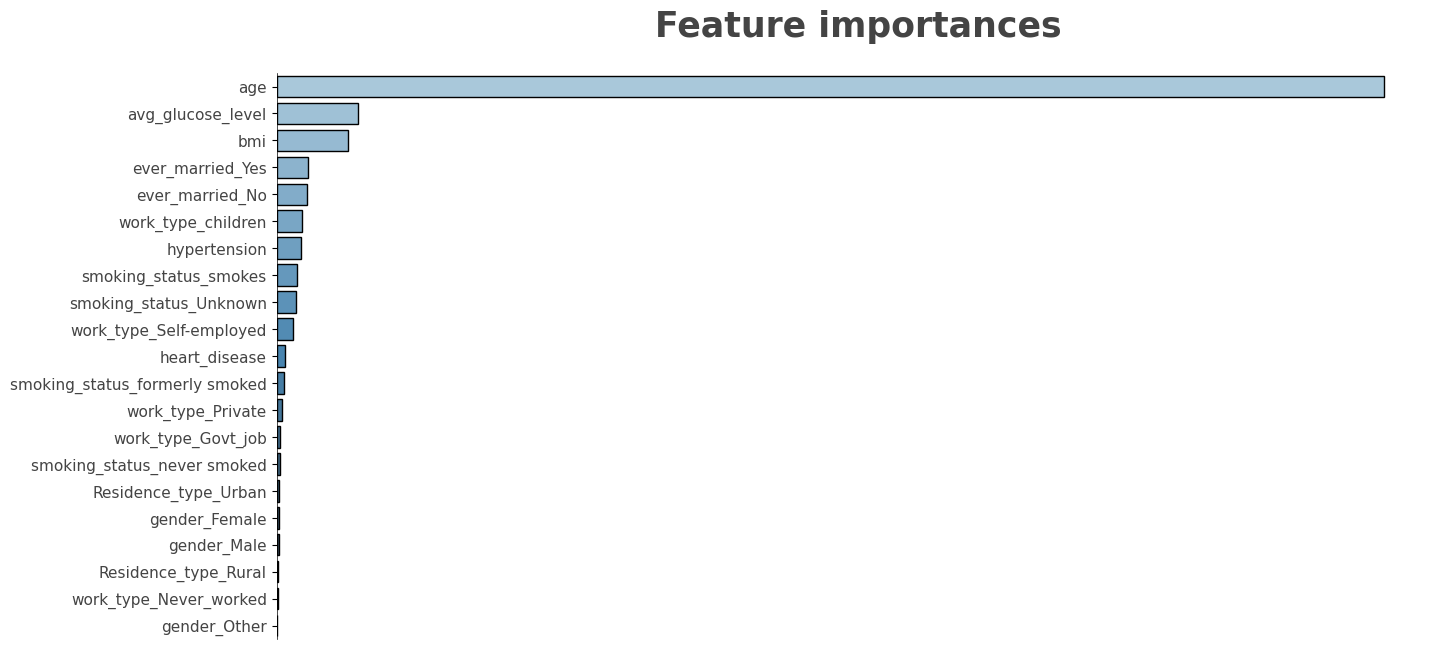

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

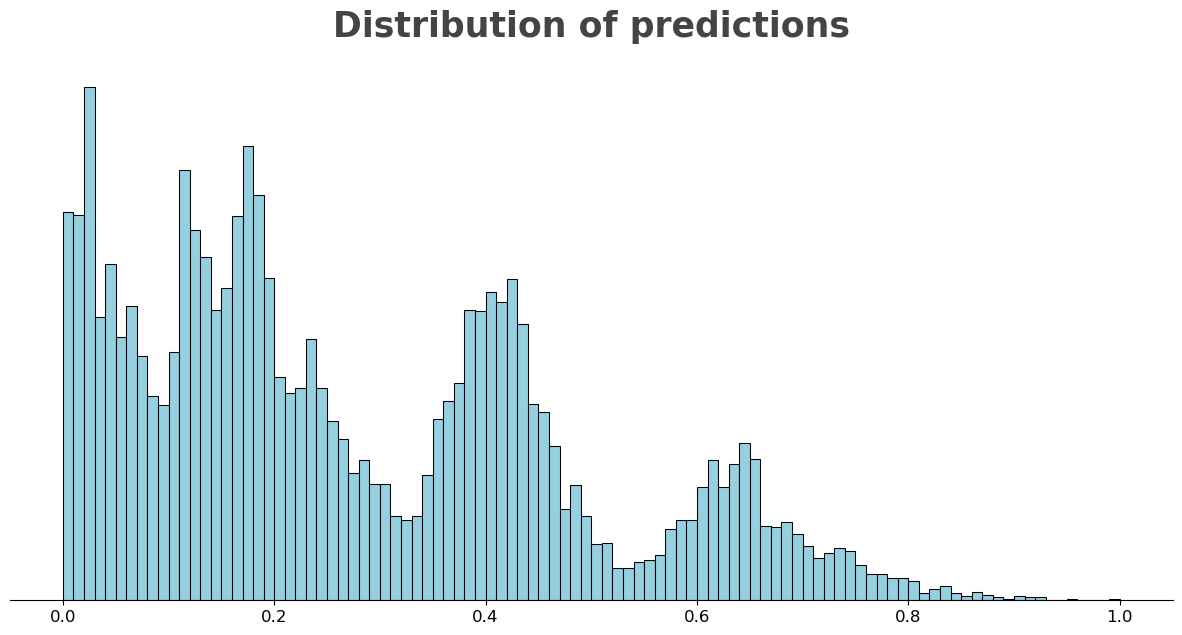

In [41]:
cb_params = {
    'depth': 3,
    'learning_rate': 0.01,
    'rsm': 0.5,
    'subsample': 0.931,
    'l2_leaf_reg': 69,
    'min_data_in_leaf': 20,
    'random_strength': 0.175,
    
    'random_seed': seed,
    'use_best_model': True,
    'task_type': 'CPU',
    'bootstrap_type': 'Bernoulli',
    'grow_policy': 'SymmetricTree',
    'loss_function': 'Logloss',
    'eval_metric': 'AUC'
}

f_imp = pd.DataFrame({'feature': X.columns})
predictions, scores = np.zeros(len(test)), []

k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):    
    cb_train = cb.Pool(data=X.iloc[train_idx],
                       label=y.iloc[train_idx])
    cb_valid = cb.Pool(data=X.iloc[val_idx],
                       label=y.iloc[val_idx])
    
    model = cb.train(params=cb_params,
                     dtrain=cb_train,
                     num_boost_round=10000,
                     evals=cb_valid, 
                     early_stopping_rounds=500,
                     verbose=False)
    
    f_imp['fold_'+str(fold+1)] = model.get_feature_importance()
    val_preds = model.predict(cb_valid)
    val_score = roc_auc_score(y.iloc[val_idx], val_preds)
    scores.append(val_score)
    
    predictions += model.predict(test) / FOLDS
    print(f'- FOLD {fold+1} AUC: {bold[0]}{round(val_score, 4)}{bold[1]} -')
    
    del cb_train, cb_valid, val_preds, val_score, model
    gc.collect()

print('*'*45)
print(f'Mean AUC: {bold[0]}{round(np.mean(scores), 4)}{bold[1]}')

predictions = norm_0to1(predictions)
f_importance_plot(f_imp)
preds_plot(predictions)

In [42]:
cb_preds = predictions
ss['stroke'] = predictions
ss.to_csv('cb_submission.csv', index=False)

# <div style="background-color:#72bfd6;text-align:center;color:white;font-size:150%;font-family:Calibri;border-radius:10px"> <b>Lasso</b></div>
<p style="text-align:justify;">
All the code was taken from <a href="https://www.kaggle.com/code/tilii7/modeling-stroke-dataset-with-lasso-regression">here</a>! Many thanks to the author and, frankly, I would never have thought of such a thing myself. The only difference is that I added stroke patients from the original dataset. Upvote his work, because he reminded us an important thing that trees and neural networks are not always the best and sometimes we need to remember about simple models!
</p>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

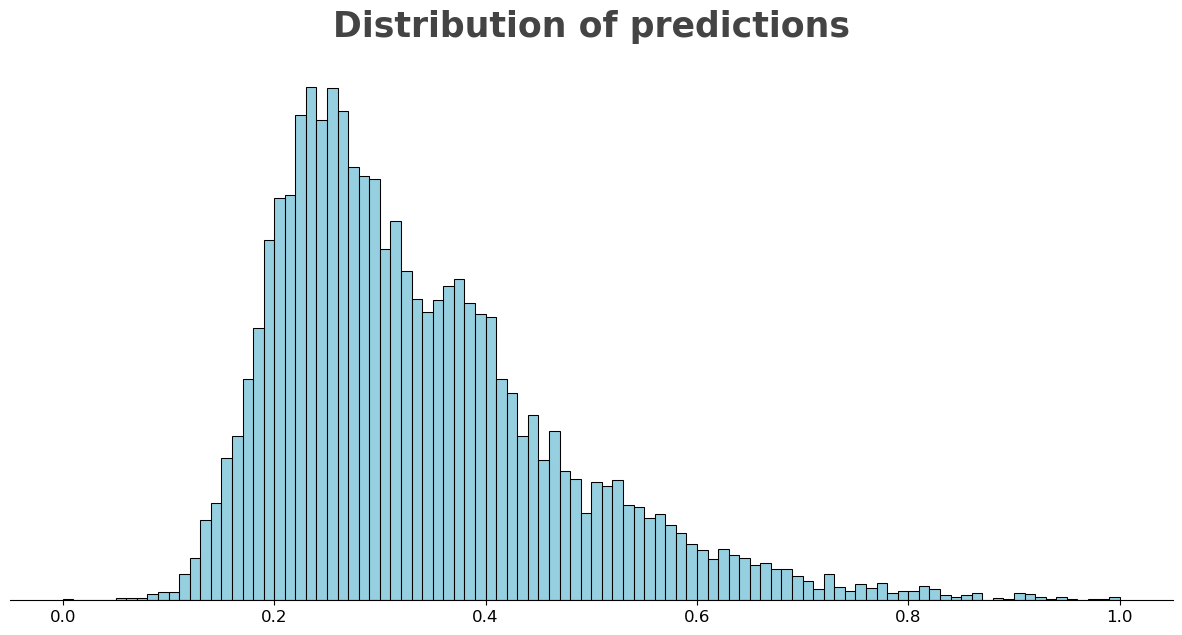

In [43]:
lasso_preds = pd.read_csv('submission.csv')['stroke']
lasso_preds = norm_0to1(lasso_preds)
preds_plot(lasso_preds)

# <div style="background-color:#72bfd6;text-align:center;color:white;font-size:150%;font-family:Calibri;border-radius:10px"> <b>NN</b></div>

In [44]:
sc = StandardScaler()
X[num_cols] = sc.fit_transform(X[num_cols])
test[num_cols] = sc.transform(test[num_cols])

X = X.values
y = y.values
test = test.values

In [49]:
def my_model():
    x_input = Input(shape=(X.shape[-1]), name='input')
    x1 = Dense(256, activation='relu')(x_input)
    d1 = Dropout(0.1)(x1)
    x2 = Dense(128, activation='relu')(d1)
    d2 = Dropout(0.1)(x2)
    x3 = Dense(64, activation='relu')(d2)
    d3 = Dropout(0.1)(x3)
    output = Dense(1, activation='sigmoid', name='output')(d3)
    
    model = Model(x_input, output, name='nn_model')
    return model

model = my_model()
plot_model(
    model, 
    to_file='nn_model.png', 
    show_shapes=True,
    show_layer_names=True
)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


319/319 [==============================] - 0s 1ms/step
- FOLD 1 AUC: 0.886 -
319/319 [==============================] - 0s 1ms/step
- FOLD 2 AUC: 0.876 -
319/319 [==============================] - 1s 2ms/step
- FOLD 3 AUC: 0.8916 -
319/319 [==============================] - 0s 1ms/step
- FOLD 4 AUC: 0.9085 -
319/319 [==============================] - 1s 2ms/step
- FOLD 5 AUC: 0.8719 -
319/319 [==============================] - 1s 2ms/step
- FOLD 6 AUC: 0.881 -
319/319 [==============================] - 1s 1ms/step
- FOLD 7 AUC: 0.8703 -
319/319 [==============================] - 1s 2ms/step
- FOLD 8 AUC: 0.8782 -
319/319 [==============================] - 0s 1ms/step
- FOLD 9 AUC: 0.9116 -
319/319 [==============================] - 1s 2ms/step
- FOLD 10 AUC: 0.8695 -
Mean AUC: 0.8845


findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: F

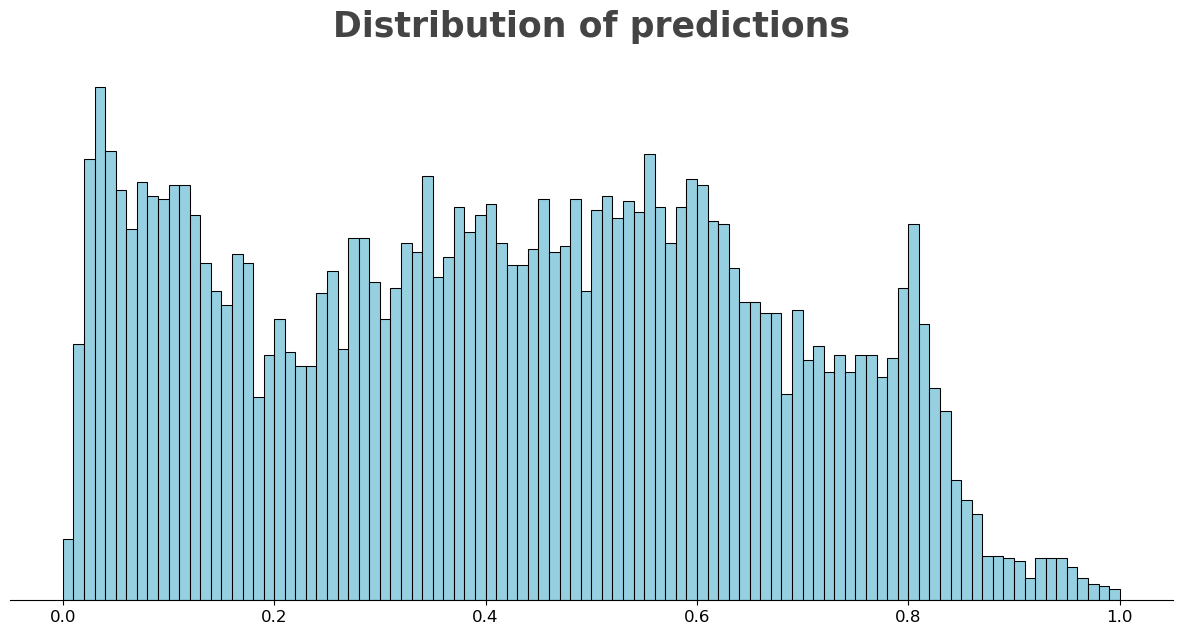

In [58]:
VERBOSE = False
BATCH_SIZE = 32
predictions, scores = [], []

lr = ReduceLROnPlateau(monitor='val_auc', factor=0.75, 
                       patience=5, verbose=VERBOSE)

es = EarlyStopping(monitor='val_auc', patience=15, 
                   verbose=VERBOSE, mode='max', 
                   restore_best_weights=True)

k = StratifiedKFold(n_splits=FOLDS, random_state=seed, shuffle=True)
for fold, (train_idx, val_idx) in enumerate(k.split(X, y)):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
        
    model = my_model()
    model.compile(optimizer='adam', 
                  loss=tfa.losses.SigmoidFocalCrossEntropy(alpha=0.1, gamma=3),
                  metrics='AUC')
        
    model.fit(X_train, y_train, 
              validation_data=(X_val, y_val), 
              epochs=300,
              verbose=VERBOSE,
              batch_size=BATCH_SIZE, 
              class_weight={0: 1, 1: 10},
              callbacks=[lr, es])
        
    y_pred = model.predict(X_val)
    y_pred = norm_0to1(y_pred)
    val_score = roc_auc_score(y_val, y_pred)
    scores.append(val_score)
    
    predictions.append(model.predict(test))
    print(f'- FOLD {fold+1} AUC: {bold[0]}{round(val_score, 4)}{bold[1]} -')
    
print(f'Mean AUC: {round(np.mean(scores), 4)}')
predictions = np.squeeze(np.mean(predictions, axis=0))
predictions = norm_0to1(predictions)
preds_plot(predictions)

In [59]:
nn_preds = predictions
ss['stroke'] = predictions
ss.to_csv('nn_submission.csv', index=False)

# <div style="background-color:#72bfd6;text-align:center;color:white;font-size:150%;font-family:Calibri;border-radius:10px"> <b>Blending</b></div>
<p style="text-align:justify;">
You may ask why I only used CatBoost? Because the results of this model turned out to be so much better than the results of LGBM and XGB. Interestingly, in the previous competition, CatBoost had the worst results compared to other trees, and the neural network (at least for me) produced very poor results. Here it's the opposite. It turned out to be a very unusual competition and I am sure that in a day the community will have a way to reach 0.895.
</p>

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


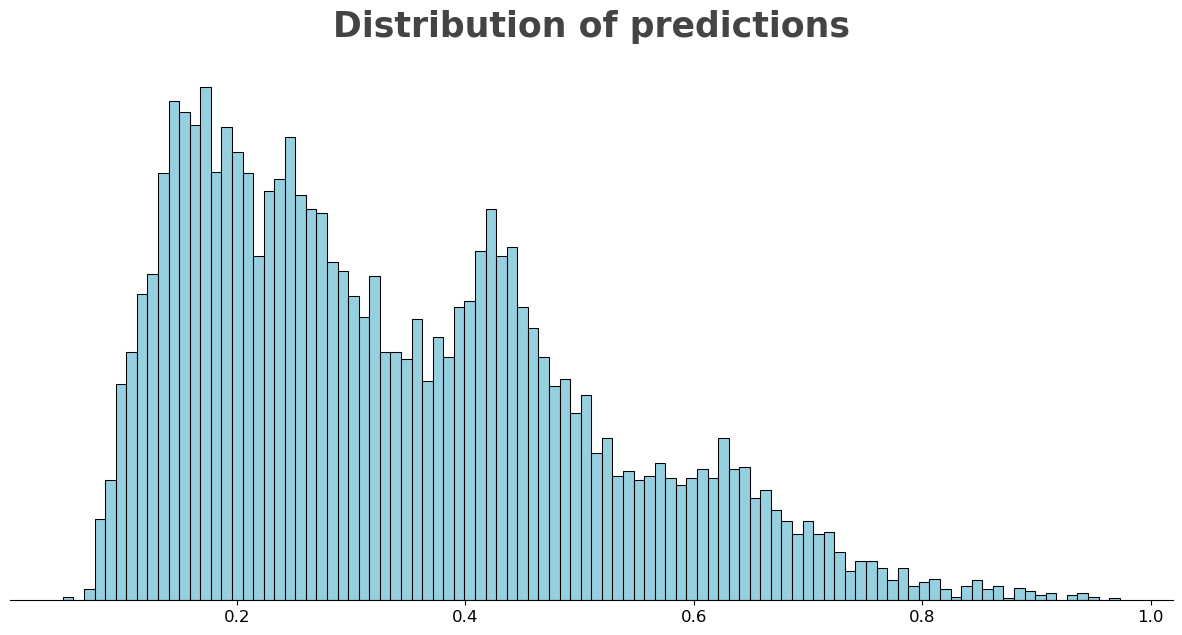

In [26]:
ss['stroke'] = (cb_preds*0.5 + nn_preds*0.5)*0.5 + lasso_preds*0.5
ss.to_csv('final_blend_submission_1.csv', index=False)
preds_plot(ss['stroke'])

findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.
findfont: Font family 'Calibri' not found.


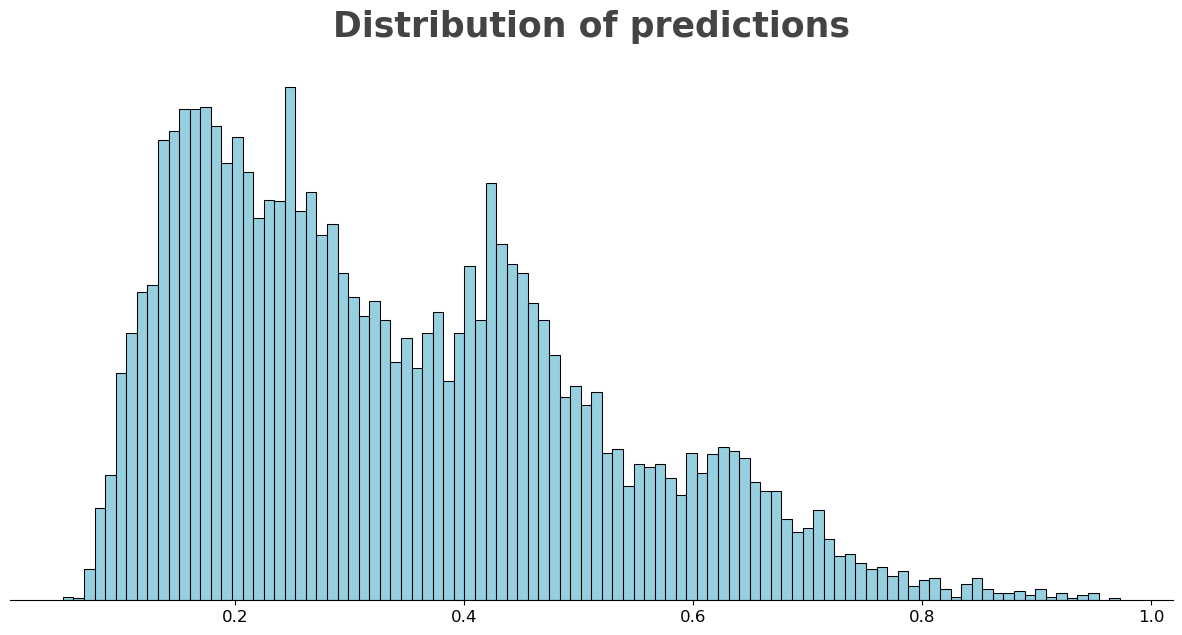

In [60]:
ss['stroke'] = ((cb_preds*0.8905 + nn_preds*0.8845) / (0.8905 + 0.8845))*0.5 + lasso_preds*0.5
ss.to_csv('final_blend_submission_3.csv', index=False)
preds_plot(ss['stroke'])